## Facies classification using ensemble classifiers 


#### by: <a href="https://ca.linkedin.com/in/evgeny-sorkin-509532b">Evgeny Sorkin</a> [SJ Geophysics](https://www.sjgeophysics.com/)

####  [Original contest notebook](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a majority-vote classifier comprised of support vector machine, random forest and XGBoosted tree.  We will use the classifiers implementation in [scikit-learn](http://scikit-learn.org) and [XGBoost](https://github.com/dmlc/xgboost)

##  Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `training_data.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 20)
pd.options.mode.chained_assignment = None

seed = 101
np.random.seed(seed)

filename = '../facies_vectors.csv'
data = pd.read_csv(filename)
training_data = data.copy()

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [16]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [4]:
training_data.columns[4:]

Index(['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'], dtype='object')

In [5]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, there are 3232 feature vectors in the training set.

In [17]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

Next: make labels and features vectors

In [18]:
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

## Feature-imputation

In [19]:
from sklearn.preprocessing import Imputer
def feat_imput(training_data, drop_columns):
    """adopted RandomForest feature regressor by ar4"""
    #imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    #X = training_data.drop(drop_columns, axis=1).values
    #X_imputed = imp.fit_transform(X)
    training_data_imputed = training_data.copy()
    #for ift,ft in enumerate(training_data.columns.drop(drop_columns)):
    #    training_data_imputed[ft] = X_imputed[:,ift]
        
    reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
    feat_labels =training_data.columns.drop(drop_columns)
    DataImpAll = training_data[feat_labels].copy()
    DataImp = DataImpAll.dropna(axis = 0, inplace=False)
    Ximp=DataImp.loc[:, DataImp.columns != 'PE']
    Yimp=DataImp.loc[:, 'PE']
    Y_PE = DataImpAll.loc[:, 'PE']
    reg.fit(Ximp, Yimp)
    Y_PE[DataImpAll.PE.isnull()] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False)) 
    training_data_imputed['PE'] = Y_PE
    #X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))    
    
    return training_data_imputed 

In [20]:
drop_columns= ['Formation', 'Well Name', 'Depth','Facies']
depth = training_data['Depth']
well = data['Well Name'].values
training_data = feat_imput(training_data,drop_columns)

##  Feature engineering 

In [21]:
def add_del(df,feat_names, depth, thesh = 1e-3):
    """"""
    for fn in feat_names:
        df["del_"+fn] = np.gradient(df[fn] )/np.gradient(depth)
    return df
def add_features(training_data,drop_columns,depth):
    """"""
    xx = add_del(training_data,[fn for fn in training_data.columns.drop(drop_columns) if fn != 'NM_M'], depth)
    xx = add_del(xx,[fn for fn in xx.columns.drop(drop_columns) if fn != 'NM_M'],depth)
    return xx
training_data.columns[4:]
training_data = add_del(training_data,[fn for fn in training_data.columns[4:] if fn != 'NM_M'],depth)
training_data = add_del(training_data,[fn for fn in training_data.columns[4:] if fn != 'NM_M'],depth)
training_data.columns[4:]
feat_labels =training_data.columns.drop(drop_columns)

In [22]:
feat_labels

Index(['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS',
       'del_GR', 'del_ILD_log10', 'del_DeltaPHI', 'del_PHIND', 'del_PE',
       'del_RELPOS', 'del_del_GR', 'del_del_ILD_log10', 'del_del_DeltaPHI',
       'del_del_PHIND', 'del_del_PE', 'del_del_RELPOS'],
      dtype='object')

import and initilize a few classifires that we play with 

In [23]:
y = training_data['Facies'].values -1
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
feat_labels =training_data.columns[4:]
label_encoded_y  = np.unique(y)

## Create wells splits for training and cross validations

In [24]:
from sklearn.model_selection import LeavePGroupsOut
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)
Xf = data[data.columns[4:]].values
yf = data['Facies'].values
custom_cv_list = []
# Generate splits
split_list = []
for train, val in lpgo.split(Xf, yf, groups=training_data['Well Name']):
    hist_tr = np.histogram(yf[train], bins=np.arange(len(facies_labels)+1)+.5)
    hist_val = np.histogram(yf[val], bins=np.arange(len(facies_labels)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
        
custom_cv = [(np.arange(len(yf)),np.arange(len(yf)))]            
# Print splits
#for s, split in enumerate(split_list):
#    print('Split %d' % s)
#print('    training:   %s' % (data['Well Name'][split['train']].unique()))
#    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

In [29]:
# the scores 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import make_scorer
# create custom scorer

def my_scorer(clf,X,y):
    """"""
    score_split = []
 
        
    for split in split_list:
       
        # Select training and validation data from current split
        X_tr = X[split['train'],:]
        X_v = X[split['val'], :]
        y_tr = y[split['train']]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_v)

        # Score
        score = f1_score(y_v, y_pred, average='micro')
        score_split.append(score)
        
    # Average score 
    return np.mean(score_split)  
pre_scorer = make_scorer(my_scorer, greater_is_better=True)

In [25]:
# random forest (the tuneup of hyperparameters was done with gridsearchCV)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( 
    n_estimators = 303,
    min_samples_leaf =1,
    random_state=seed, n_jobs=6)

In [30]:
print('Predicted F1-Score: {}'.format(my_scorer(forest,X,y)))

Predicted F1-Score: 0.5527391388985272


In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
#XGBoosted trees
import xgboost as xgb
from xgboost import XGBClassifier

/home/evgeny/.conda/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
#tuned xgb 
xg = XGBClassifier(learning_rate =0.05,
 n_estimators=331,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.6,
 colsample_bytree=0.8,
 reg_alpha=0.25,
 nthread=-1,
 objective='multi:softprob',
 scale_pos_weight=1,
 seed=seed)

#xg2.fit(X_train, y_train,eval_metric=pre_scorer)
#y_pred = xg2.predict(X_test)
#print ("F1-score: %.4g" % f1_score(y_test,y_pred, average='micro'))
print ("F1-score: %.4g" % my_scorer(xg,X,y))

F1-score: 0.561


## The combined majority vote classifier is constructed out of 3-individual classifiers

In [42]:
from sklearn.ensemble import VotingClassifier
mv = VotingClassifier(estimators=[('forest',forest),('XGBoost',xg)])
mv.fit(X,y)

VotingClassifier(estimators=[('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
          ...b', reg_alpha=0.25, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.6))],
         n_jobs=1, voting='hard', weights=None)

In [ ]:
print ("F1-score: %.4g" % my_scorer(mv,X,y))

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [38]:
well_data = pd.read_csv('../validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data.columns[4:]
depth = well_data['Depth']
well_data= add_del(well_data,[fn for fn in well_data.columns[3:] if fn != 'NM_M'], depth)
well_data = add_del(well_data,[fn for fn in well_data.columns[3:] if fn != 'NM_M'], depth)
well_data.columns[3:]
feat_labels =well_data.columns[3:] 
X_unknown = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values

In [41]:
del_added = well_data.columns[0:] 

Index(['Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI',
       'PHIND', 'PE', 'NM_M', 'RELPOS', 'del_GR', 'del_ILD_log10',
       'del_DeltaPHI', 'del_PHIND', 'del_PE', 'del_RELPOS', 'del_del_GR',
       'del_del_ILD_log10', 'del_del_DeltaPHI', 'del_del_PHIND', 'del_del_PE',
       'del_del_RELPOS'],
      dtype='object')

In [44]:
feat_labels

Index(['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS',
       'del_GR', 'del_ILD_log10', 'del_DeltaPHI', 'del_PHIND', 'del_PE',
       'del_RELPOS', 'del_del_GR', 'del_del_ILD_log10', 'del_del_DeltaPHI',
       'del_del_PHIND', 'del_del_PE', 'del_del_RELPOS'],
      dtype='object')

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [45]:
#predict facies of unclassified data
y_unknown = mv.predict(X_unknown)
well_data['Facies'] = y_unknown+1
well_data.drop(['del_GR', 'del_ILD_log10', 'del_DeltaPHI', 'del_PHIND', 'del_PE',
       'del_RELPOS', 'del_del_GR', 'del_del_ILD_log10', 'del_del_DeltaPHI',
       'del_del_PHIND', 'del_del_PE', 'del_del_RELPOS'], axis=1)

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
5,A1 SH,STUART,2810.5,73.955,0.667,6.900,12.250,3.086,1,0.889,3
6,A1 SH,STUART,2811.0,77.962,0.674,6.500,12.450,3.092,1,0.867,2
7,A1 SH,STUART,2811.5,83.894,0.667,6.300,12.650,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.700,13.050,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.300,12.950,3.127,1,0.800,2


In [46]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

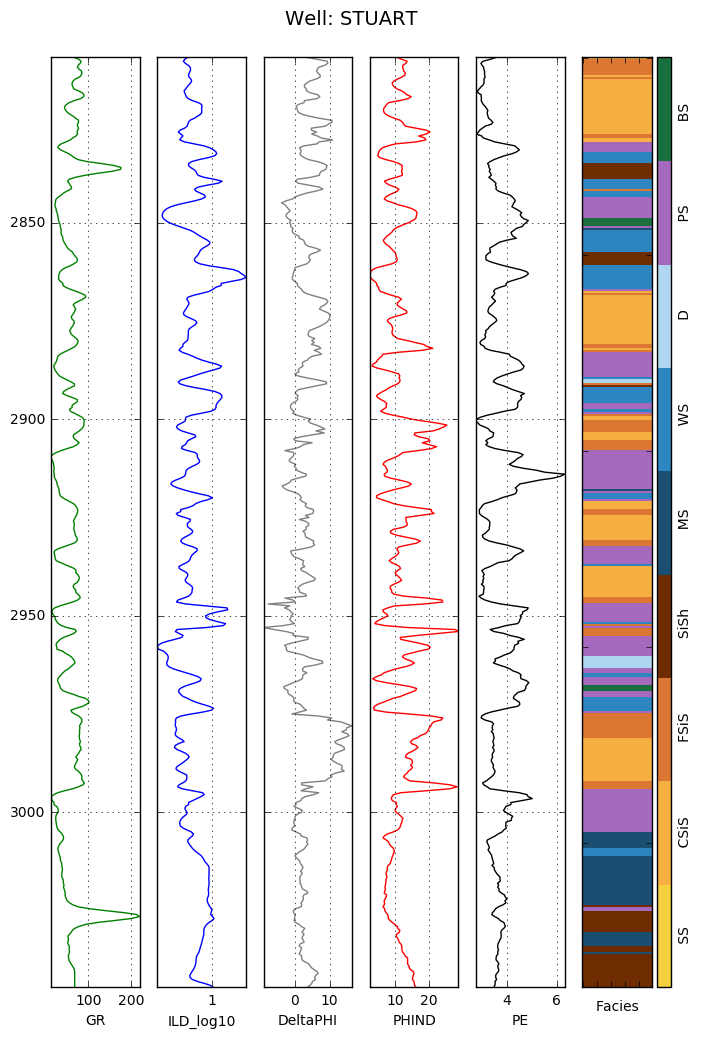

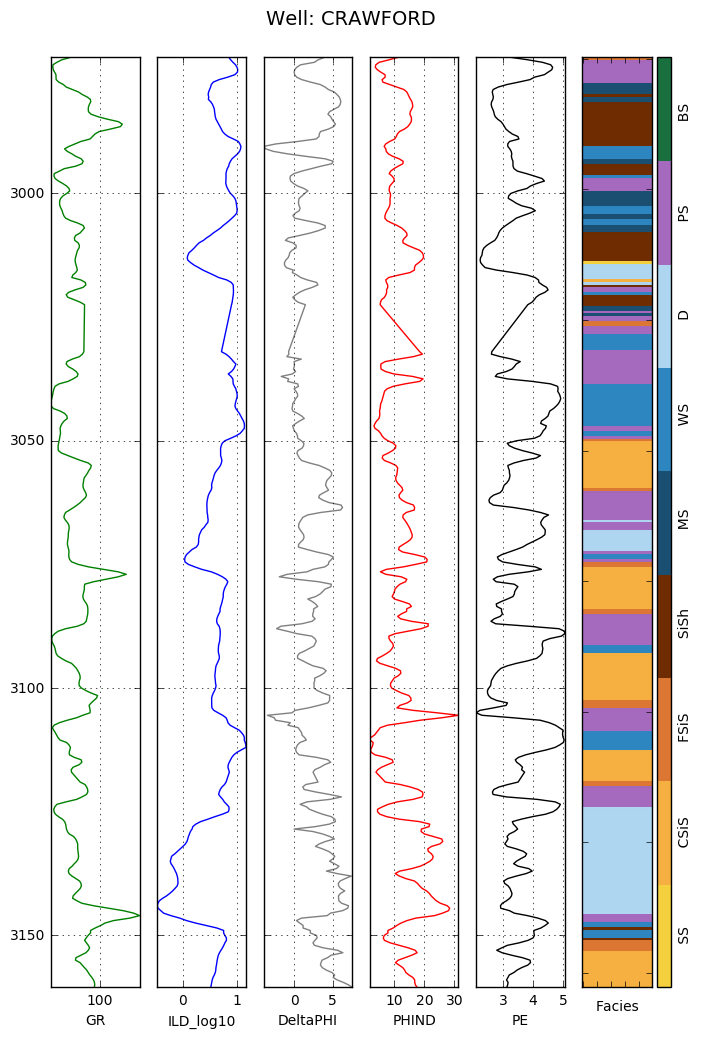

In [47]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [47]:
well_data.to_csv('well_data_with_facies.csv')